### Clustering Similar Players

In [11]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [12]:
data_02_24 = pd.read_csv('./data/cleaned/data_02_24.csv')
data_15_24 = pd.read_csv('./data/cleaned/data_15_24.csv')

fix cols

In [13]:
data_02_24 = data_02_24.drop(columns=['Unnamed: 0', 'Team'])
df = data_02_24.copy()

#### Normalization
<small> all code standard across ipynb when normalization is required (I should probably refactor into .py lol)

In [14]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
        return avg

In [15]:
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    return np.sqrt(variance)

In [16]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

In [17]:
# df to store mean results
mean_values = pd.DataFrame(index=df['Season'].unique())

for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = df.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
19,2002,473.684181,29.200233,0.088931,0.162881,0.294877,99.856949,0.221509,3.922156,-0.767819,1.888873,0.181982,0.703447,0.507012,0.860107,0.797336,0.094299,0.256508
22,2003,475.461939,29.191111,0.086575,0.159114,0.296402,99.927082,0.141683,4.016513,-0.608826,1.909976,0.221738,0.691527,0.527634,0.882055,0.800120,0.093138,0.260791
20,2004,477.651063,29.335336,0.087845,0.163399,0.299236,99.906874,0.255112,4.303784,-0.517574,1.945867,0.204546,0.693372,0.623672,0.855852,0.806547,0.088749,0.255794
14,2005,475.451649,29.259353,0.083354,0.159429,0.297611,100.116588,0.277356,3.656253,-0.893002,1.858494,0.214757,0.681891,0.550610,0.886206,0.813783,0.086017,0.255201
15,2006,483.988528,29.191618,0.085995,0.162801,0.303676,100.090682,0.168365,3.574442,-0.760455,1.862631,0.232215,0.671328,0.584224,0.889358,0.816041,0.084597,0.251676


In [18]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=df['Season'].unique())

# Loop through numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = df.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
19,2002,184.243302,4.009692,0.037986,0.055977,0.035674,31.645660,3.121745,19.286650,9.129972,2.195603,0.047095,0.056035,0.108927,0.051809,0.061293,0.032167,0.028209
22,2003,185.106060,4.078477,0.035647,0.053696,0.034696,30.915634,3.282536,17.866265,9.428022,2.134635,0.048461,0.058644,0.107443,0.047224,0.060704,0.031931,0.027495
20,2004,189.820910,4.146485,0.037057,0.057978,0.036772,30.199233,3.575905,17.922925,9.712096,2.177108,0.051101,0.059314,0.106975,0.055553,0.063824,0.033339,0.030215
14,2005,182.884548,4.155987,0.032447,0.054885,0.035186,28.238546,3.328612,16.513000,10.060394,1.953790,0.057376,0.059317,0.117271,0.047543,0.061264,0.032130,0.027910
15,2006,184.138008,4.310582,0.035272,0.055416,0.036208,28.100105,3.600161,16.729148,9.906593,1.979241,0.060376,0.059520,0.112736,0.046223,0.061019,0.031551,0.028022


In [19]:
df_zscore = z_scores(df, mean_df=mean_values, std_df=std_values)
df_zscore.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
0,brent clevlen,2007,74.826870,85.958971,74.686219,193.060161,107.344122,43.282571,98.653170,96.363387,100.657718,89.901996,138.703183,88.950287,71.666459,22.211544,37.187201,169.893575,204.596460
1,brett hayes,2009,74.297907,90.367791,72.475999,127.859623,108.219882,117.931506,99.866315,98.235778,100.843512,91.580480,170.668602,80.735141,60.421763,105.381033,65.578050,147.469352,199.428878
2,carlos peguero,2014,75.723755,96.257739,107.348483,147.612705,148.436984,92.738037,100.377615,97.711317,100.971051,91.256604,122.457976,73.452584,41.259125,91.336666,33.462464,156.578380,183.278087
3,seby zavala,2019,75.887131,92.057094,73.040518,181.646207,108.098997,44.146682,99.594613,95.874994,101.729855,90.245625,129.458257,111.272068,55.708080,34.476706,40.158323,179.134016,179.993300
4,franklin barreto,2020,77.834198,88.981943,76.647649,142.109822,78.737137,59.956124,101.610132,90.946521,99.887662,86.747334,120.942395,87.572409,55.233155,84.442687,56.517822,144.969583,165.941780


#### Clustering

<small> First Cluster for 2002-2024 Data

In [70]:
# clustering
from sklearn.cluster import KMeans

average indiv player, not by season
<br>
<br>
<small> Need to average player together so that for each player there is only one row. We can then cluster the type of career a player has and look at age progression based on such clusters

In [71]:
# borrowed from player att ipynb
def clean_names(df):
    df['Name'] = df['Name'].str.split(',').str[0]
    return df

In [72]:
df_zscore_player = clean_names(df_zscore)
df_zscore_player = df_zscore_player.groupby('Name').mean()

Amount of Clusters

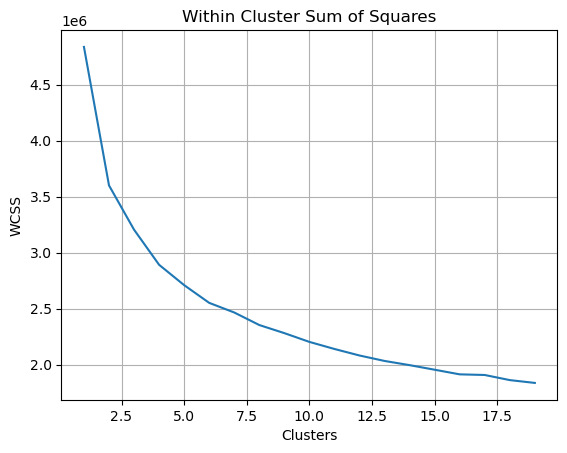

In [76]:
X = df_zscore_player.drop(columns=['Season', 'Age'])

wcss = []
for i in range(1,20):
    kmeans_clust = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans_clust.fit(X)
    wcss.append(kmeans_clust.inertia_)

plt.plot(range(1,20), wcss)
plt.title('Within Cluster Sum of Squares')
plt.ylabel('WCSS')
plt.xlabel('Clusters')
plt.grid(True)
plt.show()

Player Clusters

In [52]:
model = KMeans(n_clusters=4, init="k-means++", random_state=26)
labels = model.fit_predict(X)

add to df_zscore

In [53]:
df_zscore['Cluster'] = labels
df_zscore.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%,Cluster
0,brent clevlen,2007,74.826870,85.958971,74.686219,193.060161,107.344122,43.282571,98.653170,96.363387,100.657718,89.901996,138.703183,88.950287,71.666459,22.211544,37.187201,169.893575,204.596460,2
1,brett hayes,2009,74.297907,90.367791,72.475999,127.859623,108.219882,117.931506,99.866315,98.235778,100.843512,91.580480,170.668602,80.735141,60.421763,105.381033,65.578050,147.469352,199.428878,2
2,carlos peguero,2014,75.723755,96.257739,107.348483,147.612705,148.436984,92.738037,100.377615,97.711317,100.971051,91.256604,122.457976,73.452584,41.259125,91.336666,33.462464,156.578380,183.278087,2
3,seby zavala,2019,75.887131,92.057094,73.040518,181.646207,108.098997,44.146682,99.594613,95.874994,101.729855,90.245625,129.458257,111.272068,55.708080,34.476706,40.158323,179.134016,179.993300,2
4,franklin barreto,2020,77.834198,88.981943,76.647649,142.109822,78.737137,59.956124,101.610132,90.946521,99.887662,86.747334,120.942395,87.572409,55.233155,84.442687,56.517822,144.969583,165.941780,2


#### Cluster Means

wrc by cluster

In [55]:
cluster_means = df_zscore.groupby('Cluster').mean(numeric_only=True)
cluster_means.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,WAR,O-Swing%,Z-Swing%,O-Contact%,Z-Contact%,Contact%,SwStr%,CSW%
Cluster,,,,,,,,,,,,,,,,,,
0,2013.271347,91.275473,98.128988,100.446970,109.939730,104.552264,99.857608,99.327672,98.195058,99.039360,95.496779,101.302753,102.650936,90.581054,90.859037,90.046604,109.261700,107.591120
1,2013.215096,101.659393,100.434472,102.152982,94.176243,103.509339,104.769731,100.902248,103.262757,100.663097,103.392405,96.850711,97.265307,105.294440,105.629535,106.230355,93.609245,95.813005
2,2012.759685,79.197477,96.811912,92.317744,123.806275,82.526164,74.462429,99.485128,94.340957,100.873502,89.654143,108.191955,102.416594,83.790684,80.763023,79.929732,120.733711,122.027860
3,2012.988450,85.607019,99.925396,94.605986,98.024467,88.014439,85.834076,98.768015,92.758268,101.169805,90.470641,102.549680,99.035338,103.656158,104.168259,104.130267,96.863174,98.402031


cluster v. wrc+

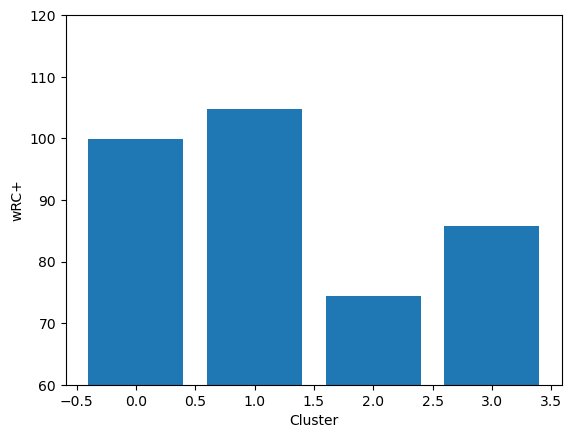

In [56]:
plt.bar(x=cluster_means.index, height=cluster_means['wRC+'])
plt.ylim(60, 120)
plt.xlabel('Cluster')
plt.ylabel('wRC+')
plt.show()

wrc+, by age, by cluster

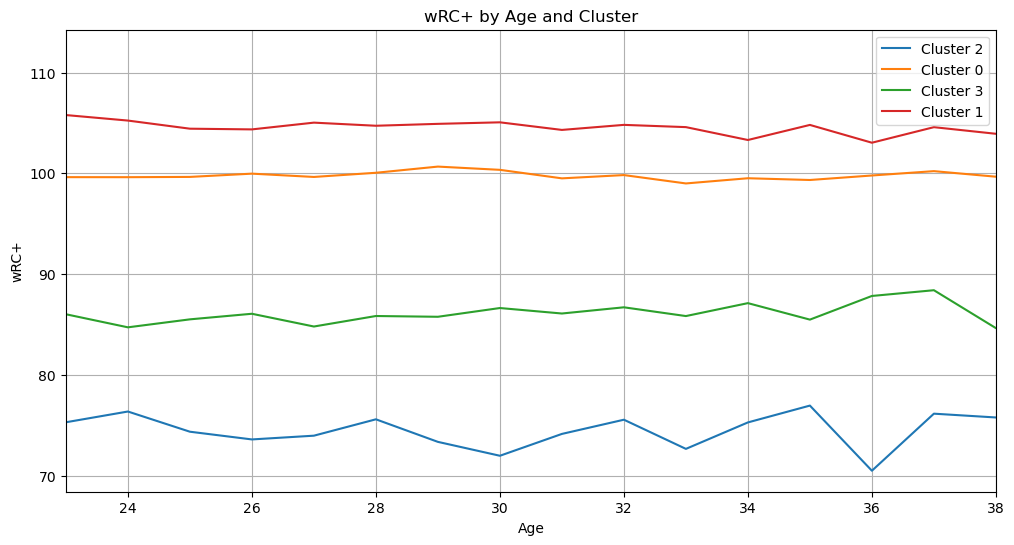

In [57]:
df_zscore_age = df_zscore.copy()
df_zscore_age['Age'] = df['Age']
cluster_means_age = df_zscore_age.groupby(['Age','Cluster']).mean(numeric_only=True)

# Plot wRC+ by age for each cluster
plt.figure(figsize=(12, 6))
for cluster in df_zscore_age['Cluster'].unique():
    cluster_data = cluster_means_age.loc[(slice(None), cluster), 'wRC+']
    plt.plot(cluster_data.index.get_level_values('Age'), cluster_data.values, label=f'Cluster {cluster}')

plt.xlabel('Age')
plt.xlim(23, 38)
plt.ylabel('wRC+')
plt.title('wRC+ by Age and Cluster')
plt.legend()
plt.grid(True)
plt.show()